# 1. Discussion and Background of the Business Problem:

Vegetarian/Vegan Restaurants

The capstone project explores the best locations for Vegetarian and Vegan people. New York is a major metropolitan area with more than 8,419 million (United States Census Bureau, 2019) people living within city limits. In addtition, New York is a popluar tourist point for people from all over the world. New York City is the largest city in the United States with a long history of international immigration. According to Top Trends in Prepared Foods 2017 report 8% of the US population is vegeterian and 6% of the US population is vegan. Hence, vegetarian/vegan food treind is getting more popular, it is important for natives and tourits to get access to the best restaruants. 


## Target Audience
* Business personnel who wants to invest or open a vegan/vegetarian restaurant.
* The eco-friendly people who care about planet and eat responsibly
* Finding the best location for opening a restaurant.
* Exploratory Data Analysis techniques to obtain necessary data, analyze it and, finally be able to tell a story out of it.


## Problem Statement
1. What is the best location for an Vegan/Vegetarian restaurant in New York City?
2. In what Neighborhood should I open a Vegan/Vegetarian restaurant to have the best chance of being successful?
3. The hint map where tourists/natives can find the biggest number of Vegan/Vegetarian restaurants


## Data Section
For this project the following data was used:

1. New York City data that contains Borough, Neighborhoods along with their coordinates (latitudes and longitudes)
    * Data Source: https://cocl.us/new_york_dataset
    * Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of New York city.
2. Vegan/Vegetarian restaurants in all neighborhood of New York city (focusing only on one neighborhood) .
    * Data Source: Foursquare API
    * Description: By using this API we will get all the venues in the Queens neighborhood. We can filter these venues to get only Vegetarian/Vegan restaurants.
    

In [71]:
import numpy as np 
import pandas as pd 
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import requests 
import os
import folium 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [213]:
import getpass
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests
ACCESS_TOKEN = 'B1VM2KPPEXKRFTYWXX441KNFTECPJA35X0OW5HSV5G22TH12' # your FourSquare Access Token
CLIENT_SECRET = 'VXQHIW1GN2LHTI4TECUUDCFMIVLHHRT2JVBDTMYVE1EFZ2PC'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
#CLIENT_ID = getpass.getpass('Enter your CLIENT_ID')
CLIENT_ID = 'EAGYUIHIGUIHHQLOKPW4EFIRSZM2QOABDDDB1LLPB00ETRRJ'
category_id = '4bf58dd8d48988d1d3941735'

In [231]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    category_id = '4bf58dd8d48988d1d3941735'
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        LIMIT = 500)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [121]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [192]:
ny_data.shape

(306, 4)

In [107]:
ny_data['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [207]:
#count=1aa
column_names=['Borough', 'Neighborhood', 'ID','Name']
vege_rest_ny=pd.DataFrame(columns=column_names)
for row in ny_data.values.tolist():
    borough, neighborhood, latitude, longitude=row
    vege_restaurants = get_venues(latitude,longitude)
    for resturant_detail in vege_restaurants.values.tolist():
        id, name , category=resturant_detail
        vege_rest_ny = vege_rest_ny.append({'Borough': borough,
                                            'Neighborhood': neighborhood, 
                                            'ID': id,
                                            'Name' : name
                                           },
                                           ignore_index=True)

In [209]:
vege_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fordham,6035f7383e9dbe076e268e0e,Bronx Blend Cafe & Juice Bar
1,Bronx,Country Club,4ec9bdfb4690116a8ecd9656,Vegetarian Joint
2,Bronx,Parkchester,5c371f9adee770002b4c3c39,Tandoori Place
3,Bronx,Olinville,50929626e4b0948956a54115,Touch A Life Health Food Services
4,Brooklyn,Greenpoint,53dd1ead498e9ef3f539fb4e,Jungle Cafe


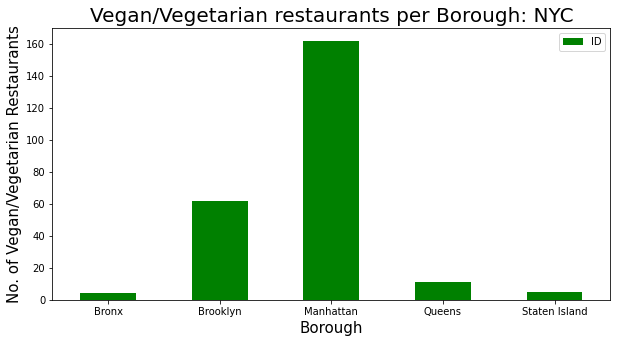

In [210]:
clr='green'
vege_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Vegan/Vegetarian restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Vegan/Vegetarian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

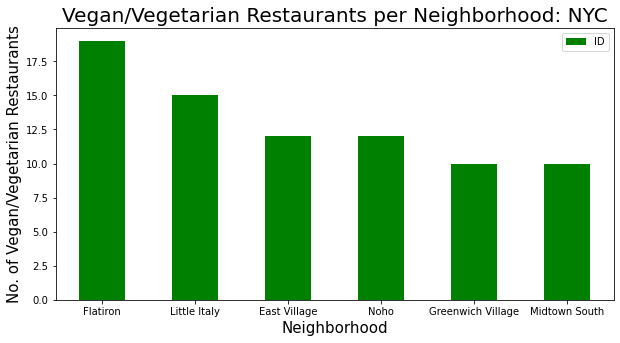

In [211]:
NOofNeigh = 6 # top number for graphing all the same past 6
vege_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Vegan/Vegetarian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Vegan/Vegetarian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [226]:
vege_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Fordham,6035f7383e9dbe076e268e0e,Bronx Blend Cafe & Juice Bar
1,Bronx,Country Club,4ec9bdfb4690116a8ecd9656,Vegetarian Joint
2,Bronx,Parkchester,5c371f9adee770002b4c3c39,Tandoori Place
3,Bronx,Olinville,50929626e4b0948956a54115,Touch A Life Health Food Services
4,Brooklyn,Greenpoint,53dd1ead498e9ef3f539fb4e,Jungle Cafe
5,Brooklyn,Greenpoint,4b9709fcf964a520c4f434e3,Paulie Gee’s
6,Brooklyn,Greenpoint,49d67571f964a520cf5c1fe3,Eat
7,Brooklyn,Greenpoint,4e56faf752b1d8d4e31329f6,Organic Deli & Grocery Corp.
8,Brooklyn,Manhattan Terrace,4ec1a58be3005ff92a8bd16e,No Meats
9,Brooklyn,Crown Heights,5a70c697dff8157fe0d76f89,Vegan's Choice


In [232]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
vege_rest_stats_ny=pd.DataFrame(columns=column_names)
for row in vege_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    vege_rest_stats_ny = vege_rest_stats_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips
                                                   },
                                                   ignore_index=True)

{'meta': {'code': 200, 'requestId': '60ba317c49d56e7e7e5b029b'}, 'response': {'venue': {'id': '6035f7383e9dbe076e268e0e', 'name': 'Bronx Blend Cafe & Juice Bar', 'contact': {'phone': '9176455753', 'formattedPhone': '(917) 645-5753'}, 'location': {'address': '113 E 184th St', 'lat': 40.8598632, 'lng': -73.9001794, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8598632, 'lng': -73.9001794}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['113 E 184th St', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bronx-blend-cafe--juice-bar/6035f7383e9dbe076e268e0e', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Sp

{'meta': {'code': 200, 'requestId': '60ba317d8e7430196428c544'}, 'response': {'venue': {'id': '50929626e4b0948956a54115', 'name': 'Touch A Life Health Food Services', 'contact': {'phone': '7189202233', 'formattedPhone': '(718) 920-2233'}, 'location': {'address': '753 Burke Ave', 'crossStreet': 'Holland Ave', 'lat': 40.871551513671875, 'lng': -73.86493682861328, 'labeledLatLngs': [{'label': 'display', 'lat': 40.871551513671875, 'lng': -73.86493682861328}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['753 Burke Ave (Holland Ave)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/touch-a-life-health-food-services/50929626e4b0948956a54115', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 

{'meta': {'code': 200, 'requestId': '60ba317e6ddddf3016e83a8b'}, 'response': {'venue': {'id': '4b9709fcf964a520c4f434e3', 'name': 'Paulie Gee’s', 'contact': {'phone': '3479873747', 'formattedPhone': '(347) 987-3747', 'twitter': 'mayank_mallick', 'instagram': 'pauliegee123', 'facebook': '208460565419', 'facebookName': "Paulie Gee's"}, 'location': {'address': '708 Continental Cir #1514', 'lat': 40.729801246987186, 'lng': -73.95852046352437, 'labeledLatLngs': [{'label': 'display', 'lat': 40.729801246987186, 'lng': -73.95852046352437}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['708 Continental Cir #1514', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/paulie-gees/4b9709fcf964a520c4f434e3', 'categories': [{'id': '4bf58dd8d48988d1ca941735', 'name': 'Pizza Place', 'pluralName': 'Pizza Places', 'shortName': 'Pizza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pi

{'meta': {'code': 200, 'requestId': '60ba317e2e31e64061d4c9da'}, 'response': {'venue': {'id': '49d67571f964a520cf5c1fe3', 'name': 'Eat', 'contact': {'phone': '7183898083', 'formattedPhone': '(718) 389-8083', 'twitter': 'eatgreenpoint'}, 'location': {'address': '124 Meserole Ave', 'crossStreet': 'at Leonard St', 'lat': 40.727413248081696, 'lng': -73.95153880119324, 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['124 Meserole Ave (at Leonard St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/eat/49d67571f964a520cf5c1fe3', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d14e941735', 'name': 'American Restaurant', 'pluralNa

{'meta': {'code': 200, 'requestId': '60ba317e9d8bc918673aa377'}, 'response': {'venue': {'id': '4e56faf752b1d8d4e31329f6', 'name': 'Organic Deli & Grocery Corp.', 'contact': {'phone': '7183499202', 'formattedPhone': '(718) 349-9202'}, 'location': {'address': '1018 Manhattan Ave', 'crossStreet': 'Green St', 'lat': 40.7336053849888, 'lng': -73.95481050112103, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7336053849888, 'lng': -73.95481050112103}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1018 Manhattan Ave (Green St)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/organic-deli--grocery-corp/4e56faf752b1d8d4e31329f6', 'categories': [{'id': '4bf58dd8d48988d146941735', 'name': 'Deli / Bodega', 'pluralName': 'Delis / Bodegas', 'shortName': 'Deli / Bodega', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/deli_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '60ba3180c3d6c5781d7e7b38'}, 'response': {'venue': {'id': '599b9f51e57ca67eb7001c01', 'name': 'A8 Pan Asian', 'contact': {'phone': '7186222088', 'formattedPhone': '(718) 622-2088'}, 'location': {'address': '268 Prospect Park W', 'lat': 40.65848743893722, 'lng': -73.98212671279907, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65848743893722, 'lng': -73.98212671279907}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['268 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/a8-pan-asian/599b9f51e57ca67eb7001c01', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '60ba3180c7a0215733c44488'}, 'response': {'venue': {'id': '5adb72c24ac28a766976217e', 'name': 'American Vegan', 'contact': {}, 'location': {'address': '612 Vanderbilt Ave', 'lat': 40.678094, 'lng': -73.968887, 'labeledLatLngs': [{'label': 'display', 'lat': 40.678094, 'lng': -73.968887}], 'postalCode': '11238', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['612 Vanderbilt Ave', 'New York, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/american-vegan/5adb72c24ac28a766976217e', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'c

{'meta': {'code': 200, 'requestId': '60ba3181368ea9012db4ec8a'}, 'response': {'venue': {'id': '52295f2293cdff812f0d0350', 'name': "Makini's Dream Natural Food Cafe", 'contact': {'phone': '7863143692', 'formattedPhone': '(786) 314-3692', 'twitter': 'makinisdream', 'facebook': '196568297180727', 'facebookUsername': 'makinisdream', 'facebookName': "Makini's Dream"}, 'location': {'address': '643 Vanderbilt Ave', 'crossStreet': 'Prospect Place and St. Marks Avenue', 'lat': 40.677786, 'lng': -73.968528, 'labeledLatLngs': [{'label': 'display', 'lat': 40.677786, 'lng': -73.968528}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['643 Vanderbilt Ave (Prospect Place and St. Marks Avenue)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/makinis-dream-natural-food-cafe/52295f2293cdff812f0d0350', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'plura

{'meta': {'code': 200, 'requestId': '60ba3182c3d6c5781d7e8217'}, 'response': {'venue': {'id': '5c33e63d86f4cc002c827cbd', 'name': 'Fuel Juice Bar', 'contact': {}, 'location': {'address': '284 Broadway', 'lat': 40.708245, 'lng': -73.958776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.708245, 'lng': -73.958776}], 'postalCode': '11211', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['284 Broadway', 'New York, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fuel-juice-bar/5c33e63d86f4cc002c827cbd', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d112941735', 'name': 'Juice Bar', 'pluralName': 'Juice Bars', 'shortName': 'Juice Bar', 'icon': {'prefix': 'ht

{'meta': {'code': 200, 'requestId': '60ba3183fa2f3075bd44462d'}, 'response': {'venue': {'id': '51ad373d498e8f3a3d903ae8', 'name': 'Edible Insight HQ', 'contact': {}, 'location': {'lat': 40.699319, 'lng': -73.926548, 'labeledLatLngs': [{'label': 'display', 'lat': 40.699319, 'lng': -73.926548}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/edible-insight-hq/51ad373d498e8f3a3d903ae8', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': Tr

{'meta': {'code': 200, 'requestId': '60ba3184af251f0bbc843d0a'}, 'response': {'venue': {'id': '3fd66200f964a52011f11ee3', 'name': 'Caffe Buon Gusto', 'contact': {'phone': '7186243838', 'formattedPhone': '(718) 624-3838'}, 'location': {'address': '151 Montague St', 'lat': 40.69461587788547, 'lng': -73.99338165894984, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69461587788547, 'lng': -73.99338165894984}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Montague St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caffe-buon-gusto/3fd66200f964a52011f11ee3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 19}, 'url': 'http://www.caff

{'meta': {'code': 200, 'requestId': '60ba318501e5b15433ddee91'}, 'response': {'venue': {'id': '5afda093012358002cfdbd9b', 'name': 'Planted', 'contact': {'phone': '9177045207', 'formattedPhone': '(917) 704-5207'}, 'location': {'address': '333 Smith St', 'lat': 40.680558, 'lng': -73.994584, 'labeledLatLngs': [{'label': 'display', 'lat': 40.680558, 'lng': -73.994584}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Smith St', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/planted/5afda093012358002cfdbd9b', 'categories': [{'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.

{'meta': {'code': 200, 'requestId': '60ba318566ae17732a2ddd9a'}, 'response': {'venue': {'id': '583b8d56a6118c60b5cfdc4b', 'name': "LuAnne's Wild Ginger", 'contact': {'phone': '7186388868', 'formattedPhone': '(718) 638-8868'}, 'location': {'address': '235 Dekalb Ave', 'crossStreet': 'Clermont Ave', 'lat': 40.689644, 'lng': -73.969824, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689644, 'lng': -73.969824}, {'label': 'entrance', 'lat': 40.689587, 'lng': -73.969828}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['235 Dekalb Ave (Clermont Ave)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/luannes-wild-ginger/583b8d56a6118c60b5cfdc4b', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/veget

{'meta': {'code': 200, 'requestId': '60ba318601e5b15433ddf1d0'}, 'response': {'venue': {'id': '5f89d605f1ae3e3895a62d3b', 'name': 'Broccoli Bar', 'contact': {}, 'location': {'address': '690 Fulton St', 'crossStreet': 's Portland ave', 'lat': 40.686134, 'lng': -73.9743, 'labeledLatLngs': [{'label': 'display', 'lat': 40.686134, 'lng': -73.9743}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['690 Fulton St (s Portland ave)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/broccoli-bar/5f89d605f1ae3e3895a62d3b', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate'

{'meta': {'code': 200, 'requestId': '60ba318747eef137c60757c8'}, 'response': {'venue': {'id': '5fd19e8e92104a245992a6b5', 'name': 'Le Petit Monstre', 'contact': {}, 'location': {'address': '82 Washington Ave', 'crossStreet': 'Park Avenue', 'lat': 40.69634, 'lng': -73.967704, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69634, 'lng': -73.967704}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82 Washington Ave (Park Avenue)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/le-petit-monstre/5fd19e8e92104a245992a6b5', 'categories': [{'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 

{'meta': {'code': 200, 'requestId': '60ba31881b7a593fe5f2ace4'}, 'response': {'venue': {'id': '4e7a2d2ae4cdb158f246cc25', 'name': 'Nile Valley', 'contact': {}, 'location': {'address': '138 Willoughby St', 'crossStreet': 'Flatbush', 'lat': 40.69160901666667, 'lng': -73.98282971666667, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69160901666667, 'lng': -73.98282971666667}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['138 Willoughby St (Flatbush)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nile-valley/4e7a2d2ae4cdb158f246cc25', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'t

{'meta': {'code': 200, 'requestId': '60ba31892a247d0fee4bfa74'}, 'response': {'venue': {'id': '4ad4a7c0f964a52085e820e3', 'name': 'Chipotle Mexican Grill', 'contact': {'phone': '9172464060', 'formattedPhone': '(917) 246-4060', 'twitter': 'chipotletweets', 'instagram': 'chipotle', 'facebook': '1433572690221956', 'facebookUsername': 'ChipotleMetrotech', 'facebookName': 'Chipotle Mexican Grill'}, 'location': {'address': '1 Metrotech Center', 'crossStreet': 'E Center Ave', 'lat': 40.69359154930046, 'lng': -73.98638792038685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69359154930046, 'lng': -73.98638792038685}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 Metrotech Center (E Center Ave)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chipotle-mexican-grill/4ad4a7c0f964a52085e820e3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralNa

{'meta': {'code': 200, 'requestId': '60ba31898e7430196428e659'}, 'response': {'venue': {'id': '51cb1540498ea4c8a8601d1f', 'name': 'Kota Cafe', 'contact': {}, 'location': {'address': '444 Atlantic Ave', 'crossStreet': 'Bond St. And Nevins St', 'lat': 40.68644311396676, 'lng': -73.98345919604755, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68644311396676, 'lng': -73.98345919604755}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['444 Atlantic Ave (Bond St. And Nevins St)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kota-cafe/51cb1540498ea4c8a8601d1f', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCo

{'meta': {'code': 200, 'requestId': '60ba318a47eef137c60760aa'}, 'response': {'venue': {'id': '5dc99b3b8a42e200084d3a11', 'name': 'Govinda’s Vegetarian Lunch', 'contact': {}, 'location': {'lat': 40.68759, 'lng': -73.982166, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68759, 'lng': -73.982166}], 'postalCode': '11217', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/govindas-vegetarian-lunch/5dc99b3b8a42e200084d3a11', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{'type': 'oth

{'meta': {'code': 200, 'requestId': '60ba318b7a4c740b07005b78'}, 'response': {'venue': {'id': '4dc09f1143a1fd4cf8819b0b', 'name': 'The Park Bentch @ Brooklyn USA', 'contact': {}, 'location': {'address': '182 Midwood St', 'lat': 40.659675, 'lng': -73.954713, 'labeledLatLngs': [{'label': 'display', 'lat': 40.659675, 'lng': -73.954713}, {'label': 'entrance', 'lat': 40.659741, 'lng': -73.954722}], 'postalCode': '11225', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['182 Midwood St', 'Brooklyn, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-park-bentch--brooklyn-usa/4dc09f1143a1fd4cf8819b0b', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '60ba318cfa2f3075bd445d1d'}, 'response': {'venue': {'id': '4a2048e8f964a520687c1fe3', 'name': 'Champs Diner', 'contact': {'phone': '7185992743', 'formattedPhone': '(718) 599-2743', 'twitter': 'champs_family', 'instagram': 'champsdiner', 'facebook': '152965744742042', 'facebookUsername': 'champsvegan', 'facebookName': 'Champs Diner'}, 'location': {'address': '197 Meserole St', 'crossStreet': 'btwn Bushwick Ave & Humboldt St', 'lat': 40.70833454520133, 'lng': -73.94081610648125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70833454520133, 'lng': -73.94081610648125}], 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['197 Meserole St (btwn Bushwick Ave & Humboldt St)', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/champs-diner/4a2048e8f964a520687c1fe3', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', '

{'meta': {'code': 200, 'requestId': '60ba318c0319445be236309a'}, 'response': {'venue': {'id': '4d30d940f714236ab68b7ca5', 'name': 'Azure Natural & Organic Foods', 'contact': {'phone': '7185997887', 'formattedPhone': '(718) 599-7887'}, 'location': {'address': '187 Montrose Ave', 'crossStreet': 'at Humboldt St.', 'lat': 40.70764375349692, 'lng': -73.94160407605526, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70764375349692, 'lng': -73.94160407605526}, {'label': 'entrance', 'lat': 40.707588, 'lng': -73.941692}], 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['187 Montrose Ave (at Humboldt St.)', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/azure-natural--organic-foods/4d30d940f714236ab68b7ca5', 'categories': [{'id': '4bf58dd8d48988d146941735', 'name': 'Deli / Bodega', 'pluralName': 'Delis / Bodegas', 'shortName': 'Deli / Bodega', 'icon': {'prefix': 'https://ss3.4sqi.net/img/

{'meta': {'code': 200, 'requestId': '60ba318d5fb0fb2e9b415a83'}, 'response': {'venue': {'id': '4a314895f964a520ac991fe3', 'name': 'Boulevard Cafe', 'contact': {'phone': '7183812442', 'formattedPhone': '(718) 381-2442'}, 'location': {'address': '253 Bushwick Ave', 'crossStreet': 'btw. Montrose & Johnson', 'lat': 40.70721962577945, 'lng': -73.9397622260417, 'postalCode': '11206', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['253 Bushwick Ave (btw. Montrose & Johnson)', 'Brooklyn, NY 11206', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/boulevard-cafe/4a314895f964a520ac991fe3', 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop', 'pluralName': 'Coffee Shops', 'shortName': 'Coffee Shop', 'icon': {'prefix'

{'meta': {'code': 200, 'requestId': '60ba318ddb321b25f789375e'}, 'response': {'venue': {'id': '548c7da0498ea6aa0e8e5a1d', 'name': 'sweetgreen', 'contact': {'phone': '3479873863', 'formattedPhone': '(347) 987-3863', 'twitter': 'sweetgreen', 'facebook': '85461563560', 'facebookUsername': 'sweetgreen', 'facebookName': 'sweetgreen'}, 'location': {'address': '162 N 4th St', 'crossStreet': 'at Bedford Ave', 'lat': 40.7157953, 'lng': -73.9591804, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.715792, 'lng': -73.959071}, {'label': 'display', 'lat': 40.7157953, 'lng': -73.9591804}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['162 N 4th St (at Bedford Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sweetgreen/548c7da0498ea6aa0e8e5a1d', 'categories': [{'id': '4bf58dd8d48988d1bd941735', 'name': 'Salad Place', 'pluralName': 'Salad Places', 'shortName': 'Salad', 'icon': {'prefix'

{'meta': {'code': 200, 'requestId': '60ba318d5fb0fb2e9b415c61'}, 'response': {'venue': {'id': '58bf5a738cb34e395a372b58', 'name': 'by CHLOE.', 'contact': {'phone': '2122908000', 'formattedPhone': '(212) 290-8000', 'twitter': 'eatbychloe', 'facebook': '397164830658824', 'facebookUsername': 'byCHLOEWilliamsburg', 'facebookName': 'by CHLOE.'}, 'location': {'address': '171 N 3rd St', 'lat': 40.7152143, 'lng': -73.9593632, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7152143, 'lng': -73.9593632}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['171 N 3rd St', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/by-chloe/58bf5a738cb34e395a372b58', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/veget

{'meta': {'code': 200, 'requestId': '60ba318e8e7430196428f344'}, 'response': {'venue': {'id': '5b51d25f838e59002c6c84e9', 'name': 'The Butcher’s Daughter', 'contact': {'instagram': 'thebutchersdaughter_official'}, 'location': {'address': '271 Metropolitan Ave.', 'lat': 40.714905, 'lng': -73.95852, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714905, 'lng': -73.95852}], 'postalCode': '11211', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['271 Metropolitan Ave.', 'New York, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-butchers-daughter/5b51d25f838e59002c6c84e9', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vegetarian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 9}, 'url': 'http

{'meta': {'code': 200, 'requestId': '60ba318ea5bf3b7c749b9a03'}, 'response': {'venue': {'id': '5b216fa1a423620039595906', 'name': 'Dig Inn', 'contact': {'phone': '7182156844', 'formattedPhone': '(718) 215-6844', 'twitter': 'diginn', 'instagram': 'diginn', 'facebook': '1883810955244872', 'facebookName': 'Dig Inn'}, 'location': {'address': '166 N 4th Street', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71569849999999, 'lng': -73.9590152, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71569849999999, 'lng': -73.9590152}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['166 N 4th Street (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dig-inn/5b216fa1a423620039595906', 'categories': [{'id': '4bf58dd8d48988d14e941735', 'name': 'American Restaurant', 'pluralName': 'American Restaurants', 'shortName': 'American', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '60ba318e66ae17732a2df75c'}, 'response': {'venue': {'id': '4d8d2c60c1b1721ecedb1246', 'name': 'The Shanti Shack', 'contact': {'phone': '3474639886', 'formattedPhone': '(347) 463-9886', 'twitter': 'shantishack', 'facebook': '171268879554426', 'facebookUsername': 'theshantishack', 'facebookName': 'the shanti shack'}, 'location': {'address': '85 N 3rd St', 'lat': 40.71689324918532, 'lng': -73.96237803401777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71689324918532, 'lng': -73.96237803401777}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['85 N 3rd St', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-shanti-shack/4d8d2c60c1b1721ecedb1246', 'categories': [{'id': '4bf58dd8d48988d1d3941735', 'name': 'Vegetarian / Vegan Restaurant', 'pluralName': 'Vegetarian / Vegan Restaurants', 'shortName': 'Vegetarian / Vegan', 'icon': {'prefix': 'https

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '60ba318fcb0e5a6ced699c95'}, 'response': {}}


KeyError: 'venue'

## Free forsquareAPI does not allow to make any more requests - I am going forward with obtained results

In [233]:
vege_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fordham,0,0,0,0,0
1,Bronx,Country Club,0,0,0,0,0
2,Bronx,Parkchester,0,0,0,0,0
3,Bronx,Olinville,0,0,0,0,0
4,Brooklyn,Greenpoint,53dd1ead498e9ef3f539fb4e,Jungle Cafe,89,8,34
5,Brooklyn,Greenpoint,4b9709fcf964a520c4f434e3,Paulie Gee’s,1263,9.3,396
6,Brooklyn,Greenpoint,49d67571f964a520cf5c1fe3,Eat,22,6.5,19
7,Brooklyn,Greenpoint,0,0,0,0,0
8,Brooklyn,Manhattan Terrace,0,0,0,0,0
9,Brooklyn,Crown Heights,0,0,0,0,0


In [238]:
vege_rest_stats_ny.shape

(50, 7)

We got statistics for all 50 Green Restaurants in New York city.

In [234]:
vege_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [258]:
vege_rest_stats_ny['Likes'] = vege_rest_stats_ny['Likes'].astype('float64')
vege_rest_stats_ny['Rating'] = vege_rest_stats_ny['Rating'].astype('float64')
vege_rest_stats_ny['Tips'] = vege_rest_stats_ny['Tips'].astype('float64')
vege_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [259]:
vege_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,79.820000,3.896000,25.240000
std,217.028042,3.998467,69.364627
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,3.500000,2.900000,1.000000
75%,46.500000,8.225000,13.000000
max,1263.000000,9.300000,396.000000


### Resturant with maximum Likes

In [260]:
vege_rest_stats_ny.iloc[vege_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              4b9709fcf964a520c4f434e3
Name                        Paulie Gee’s
Likes                               1263
Rating                               9.3
Tips                                 396
Name: 5, dtype: object

### Resturant with maximum Ratings


In [261]:
vege_rest_stats_ny.iloc[vege_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              4b9709fcf964a520c4f434e3
Name                        Paulie Gee’s
Likes                               1263
Rating                               9.3
Tips                                 396
Name: 5, dtype: object

In [262]:
vege_rest_stats_ny.iloc[vege_rest_stats_ny['Tips'].idxmax()]


Borough                         Brooklyn
Neighborhood                  Greenpoint
ID              4b9709fcf964a520c4f434e3
Name                        Paulie Gee’s
Likes                               1263
Rating                               9.3
Tips                                 396
Name: 5, dtype: object

In [263]:
vege_rest_stats_ny.groupby('Neighborhood', as_index=False).mean()

,Neighborhood,Likes,Rating,Tips
0,Boerum Hill,90.250000,2.200000,30.750000
1,Brooklyn Heights,35.500000,6.700000,12.000000
2,Bushwick,3.000000,2.433333,0.666667
3,Carroll Gardens,19.000000,7.500000,9.000000
4,Clinton Hill,0.000000,0.000000,0.000000
5,Coney Island,0.000000,0.000000,0.000000
6,Country Club,0.000000,0.000000,0.000000
7,Crown Heights,0.000000,0.000000,0.000000
8,Downtown,46.250000,3.100000,20.250000
9,East Williamsburg,215.750000,8.275000,96.500000


In [282]:
ny_neighborhood_stats=vege_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns = ['Neighborhood','Avg Rating']
ny_neighborhood_stats = ny_neighborhood_stats[['Neighborhood','Avg Rating']]
ny_neighborhood_stats.sort_values(['Avg Rating'],ascending=False).head(10)

,Neighborhood,Avg Rating
14,North Side,8.420000
15,Ocean Hill,8.300000
9,East Williamsburg,8.275000
3,Carroll Gardens,7.500000
1,Brooklyn Heights,6.700000
12,Greenpoint,5.950000
11,Fort Greene,4.966667
8,Downtown,3.100000
18,Prospect Heights,2.980000
20,Williamsburg,2.766667


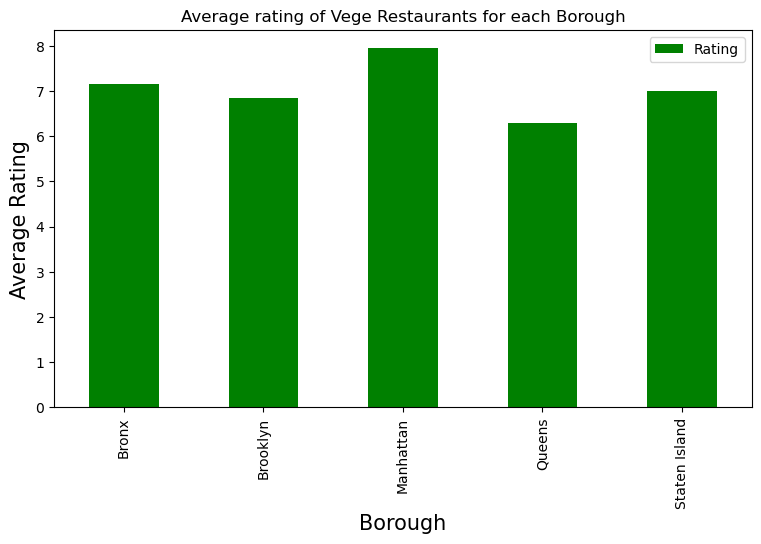

In [283]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Vege Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [285]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Avg Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Avg Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,2.200000
1,Brooklyn,Brooklyn Heights,40.695864,-73.993782,6.700000
2,Brooklyn,Bushwick,40.698116,-73.925258,2.433333
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,7.500000
4,Brooklyn,Clinton Hill,40.693229,-73.967843,0.000000
5,Brooklyn,Coney Island,40.574293,-73.988683,0.000000
6,Bronx,Country Club,40.844246,-73.824099,0.000000
7,Brooklyn,Crown Heights,40.670829,-73.943291,0.000000
8,Brooklyn,Downtown,40.690844,-73.983463,3.100000
9,Brooklyn,East Williamsburg,40.708492,-73.938858,8.275000


In [287]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Avg Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)